# Correlation Matrices

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "data-cleaning-stability":
    os.chdir("../../../..")

print('Current location: ', os.getcwd())

Current location:  /Users/denys_herasymuk/Research/NYU/ML_Lifecycle_Project/Code/data-cleaning-stability


In [4]:
import pandas as pd
from configs.constants import (ACS_INCOME_DATASET, ACS_EMPLOYMENT_DATASET, LAW_SCHOOL_DATASET, GERMAN_CREDIT_DATASET,
                               CARDIOVASCULAR_DISEASE_DATASET, BANK_MARKETING_DATASET, DIABETES_DATASET)
from source.visualizations.correlations_viz import get_data_for_correlation_plots
from notebooks.EDA.EDA_utils import get_correlation_matrix_by_target_names

## Define global configs

In [5]:
from source.custom_classes.database_client import DatabaseClient, get_secrets_path

db_client_1 = DatabaseClient()
db_client_3 = DatabaseClient(secrets_path=get_secrets_path('secrets_3.env'))
db_client_1.connect()
db_client_3.connect()

In [6]:
METRIC_NAMES = ['F1', 'Label_Stability', 'Equalized_Odds_TPR']

DATASETS_ALL_SENSITIVE_ATTRS = {
    ACS_INCOME_DATASET: ['SEX', 'RAC1P', 'SEX&RAC1P'],
    LAW_SCHOOL_DATASET: ['male', 'race', 'male&race'],
    GERMAN_CREDIT_DATASET: ['sex', 'age', 'sex&age'],
    CARDIOVASCULAR_DISEASE_DATASET: ['gender'],
    BANK_MARKETING_DATASET: ['age'],
    DIABETES_DATASET: ['Gender'],
    ACS_EMPLOYMENT_DATASET: ['SEX', 'RAC1P', 'SEX&RAC1P'],
}

DATASETS_SENSITIVE_ATTRS = {
    ACS_INCOME_DATASET: 'SEX&RAC1P',
    LAW_SCHOOL_DATASET: 'male&race',
    GERMAN_CREDIT_DATASET: 'sex',
    CARDIOVASCULAR_DISEASE_DATASET: 'gender',
    BANK_MARKETING_DATASET: 'age',
    DIABETES_DATASET: 'Gender',
    ACS_EMPLOYMENT_DATASET: 'SEX&RAC1P',
}

## Read a dataframe with all metrics

In [7]:
metrics_df = get_data_for_correlation_plots(db_client_1=db_client_1,
                                            db_client_3=db_client_3,
                                            dataset_names=[DIABETES_DATASET],
                                            missingness_types=['single_mechanism', 'multi_mechanism', 'missingness_shift'],
                                            metric_names=METRIC_NAMES,
                                            dataset_to_group=DATASETS_SENSITIVE_ATTRS)
metrics_df.shape

Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for "F1 metric and "single_mechanism" missingness type
Extracted data for diabetes
Extracted data for "F1 metric and "multi_mechanism" missingness type
Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for "F1 metric and "missingness_shift" missingness type
Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for "Label_Stability metric and "single_mechanism" missingness type
Extracted data for diabetes
Extracted data for "Label_Stability metric and "multi_mechanism" missingness type
Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for diabetes
Extracted data for "Label_Stability metric and "missingness_shift

(7614, 12)

In [8]:
metrics_df.head()

,Dataset_Name,Null_Imputer_Name,Evaluation_Scenario,Virny_Random_State,Model_Name,Subgroup,Metric,Metric_Value,Test_Set_Index,Test_Injection_Scenario,Missingness_Type,Train_Injection_Scenario
2,diabetes,median-dummy,exp1_mcar3,100,dt_clf,overall,F1,0.723684,0,MCAR3,single_mechanism,MCAR3
3,diabetes,median-dummy,exp1_mcar3,100,lr_clf,overall,F1,0.748387,0,MCAR3,single_mechanism,MCAR3
7,diabetes,median-mode,exp1_mcar3,100,dt_clf,overall,F1,0.787097,0,MCAR3,single_mechanism,MCAR3
10,diabetes,median-dummy,exp1_mcar3,200,dt_clf,overall,F1,0.816901,0,MCAR3,single_mechanism,MCAR3
13,diabetes,median-mode,exp1_mcar3,200,dt_clf,overall,F1,0.816901,0,MCAR3,single_mechanism,MCAR3


In [9]:
pivoted_metrics_df = metrics_df.pivot(columns='Metric', values='Metric_Value',
                                      index=[col for col in metrics_df.columns
                                             if col not in ('Metric', 'Metric_Value', 'Subgroup')]).reset_index()

metric_name_to_formatted_metric = {
    'Equalized_Odds_TPR': 'TPRD',
    'Equalized_Odds_TNR': 'TNRD',
    'Equalized_Odds_FPR': 'FPRD',
    'Equalized_Odds_FNR': 'FNRD',
}
pivoted_metrics_df = pivoted_metrics_df.rename(columns=metric_name_to_formatted_metric)

In [10]:
# Create a reversed metric for equalized odds metrics so that higher reversed metrics have better fairness
for reversed_metric in ['TPRD', 'TNRD', 'FPRD', 'FNRD']:
    if reversed_metric in pivoted_metrics_df.columns:
        pivoted_metrics_df[reversed_metric + '_Reversed'] = 1 - pivoted_metrics_df[reversed_metric].abs()

In [11]:
pivoted_metrics_df.head(10)

Metric,Dataset_Name,Null_Imputer_Name,Evaluation_Scenario,Virny_Random_State,Model_Name,Test_Set_Index,Test_Injection_Scenario,Missingness_Type,Train_Injection_Scenario,TPRD,F1,Label_Stability,TPRD_Reversed
0,diabetes,automl,exp1_mar3,100,dt_clf,0,MCAR3,missingness_shift,MAR3,0.187755,0.743590,0.809706,0.812245
1,diabetes,automl,exp1_mar3,100,dt_clf,1,MAR3,single_mechanism,MAR3,0.236735,0.748387,0.811912,0.763265
2,diabetes,automl,exp1_mar3,100,dt_clf,2,MNAR3,missingness_shift,MAR3,0.200000,0.723684,0.822647,0.800000
3,diabetes,automl,exp1_mar3,100,gandalf_clf,0,MCAR3,missingness_shift,MAR3,0.244898,0.779221,0.819559,0.755102
4,diabetes,automl,exp1_mar3,100,gandalf_clf,1,MAR3,single_mechanism,MAR3,0.244898,0.774194,0.821471,0.755102
5,diabetes,automl,exp1_mar3,100,gandalf_clf,2,MNAR3,missingness_shift,MAR3,0.236735,0.763158,0.818235,0.763265
6,diabetes,automl,exp1_mar3,100,lgbm_clf,0,MCAR3,missingness_shift,MAR3,0.208163,0.750000,0.922059,0.791837
7,diabetes,automl,exp1_mar3,100,lgbm_clf,1,MAR3,single_mechanism,MAR3,0.257143,0.754967,0.924706,0.742857
8,diabetes,automl,exp1_mar3,100,lgbm_clf,2,MNAR3,missingness_shift,MAR3,0.200000,0.738255,0.925882,0.800000
9,diabetes,automl,exp1_mar3,100,lr_clf,0,MCAR3,missingness_shift,MAR3,0.281633,0.773006,0.907794,0.718367


## Use one-hot encoding to compute correlations

In [12]:
target_columns = ['Missingness_Type', 'Null_Imputer_Name', 'Model_Name']
metrics_df_encoded = pd.get_dummies(pivoted_metrics_df, columns=target_columns)  # One-hot encode specific columns
metrics_df_encoded.columns

Index(['Dataset_Name', 'Evaluation_Scenario', 'Virny_Random_State',
       'Test_Set_Index', 'Test_Injection_Scenario', 'Train_Injection_Scenario',
       'TPRD', 'F1', 'Label_Stability', 'TPRD_Reversed',
       'Missingness_Type_missingness_shift',
       'Missingness_Type_multi_mechanism', 'Missingness_Type_single_mechanism',
       'Null_Imputer_Name_automl', 'Null_Imputer_Name_boost_clean',
       'Null_Imputer_Name_datawig', 'Null_Imputer_Name_deletion',
       'Null_Imputer_Name_k_means_clustering',
       'Null_Imputer_Name_median-dummy', 'Null_Imputer_Name_median-mode',
       'Null_Imputer_Name_miss_forest', 'Model_Name_boost_clean',
       'Model_Name_dt_clf', 'Model_Name_gandalf_clf', 'Model_Name_lgbm_clf',
       'Model_Name_lr_clf', 'Model_Name_mlp_clf', 'Model_Name_rf_clf'],
      dtype='object')

In [13]:
metrics_df_encoded.head(10)

,Dataset_Name,Evaluation_Scenario,Virny_Random_State,Test_Set_Index,Test_Injection_Scenario,Train_Injection_Scenario,TPRD,F1,Label_Stability,TPRD_Reversed,...,Null_Imputer_Name_median-dummy,Null_Imputer_Name_median-mode,Null_Imputer_Name_miss_forest,Model_Name_boost_clean,Model_Name_dt_clf,Model_Name_gandalf_clf,Model_Name_lgbm_clf,Model_Name_lr_clf,Model_Name_mlp_clf,Model_Name_rf_clf
0,diabetes,exp1_mar3,100,0,MCAR3,MAR3,0.187755,0.743590,0.809706,0.812245,...,0,0,0,0,1,0,0,0,0,0
1,diabetes,exp1_mar3,100,1,MAR3,MAR3,0.236735,0.748387,0.811912,0.763265,...,0,0,0,0,1,0,0,0,0,0
2,diabetes,exp1_mar3,100,2,MNAR3,MAR3,0.200000,0.723684,0.822647,0.800000,...,0,0,0,0,1,0,0,0,0,0
3,diabetes,exp1_mar3,100,0,MCAR3,MAR3,0.244898,0.779221,0.819559,0.755102,...,0,0,0,0,0,1,0,0,0,0
4,diabetes,exp1_mar3,100,1,MAR3,MAR3,0.244898,0.774194,0.821471,0.755102,...,0,0,0,0,0,1,0,0,0,0
5,diabetes,exp1_mar3,100,2,MNAR3,MAR3,0.236735,0.763158,0.818235,0.763265,...,0,0,0,0,0,1,0,0,0,0
6,diabetes,exp1_mar3,100,0,MCAR3,MAR3,0.208163,0.750000,0.922059,0.791837,...,0,0,0,0,0,0,1,0,0,0
7,diabetes,exp1_mar3,100,1,MAR3,MAR3,0.257143,0.754967,0.924706,0.742857,...,0,0,0,0,0,0,1,0,0,0
8,diabetes,exp1_mar3,100,2,MNAR3,MAR3,0.200000,0.738255,0.925882,0.800000,...,0,0,0,0,0,0,1,0,0,0
9,diabetes,exp1_mar3,100,0,MCAR3,MAR3,0.281633,0.773006,0.907794,0.718367,...,0,0,0,0,0,0,0,1,0,0


## Create a correlation matrix 

In [14]:
columns_for_correlation = []
for col in metrics_df_encoded.columns:
    for target_column in target_columns:
        if col.startswith(target_column):
            columns_for_correlation.append(col)

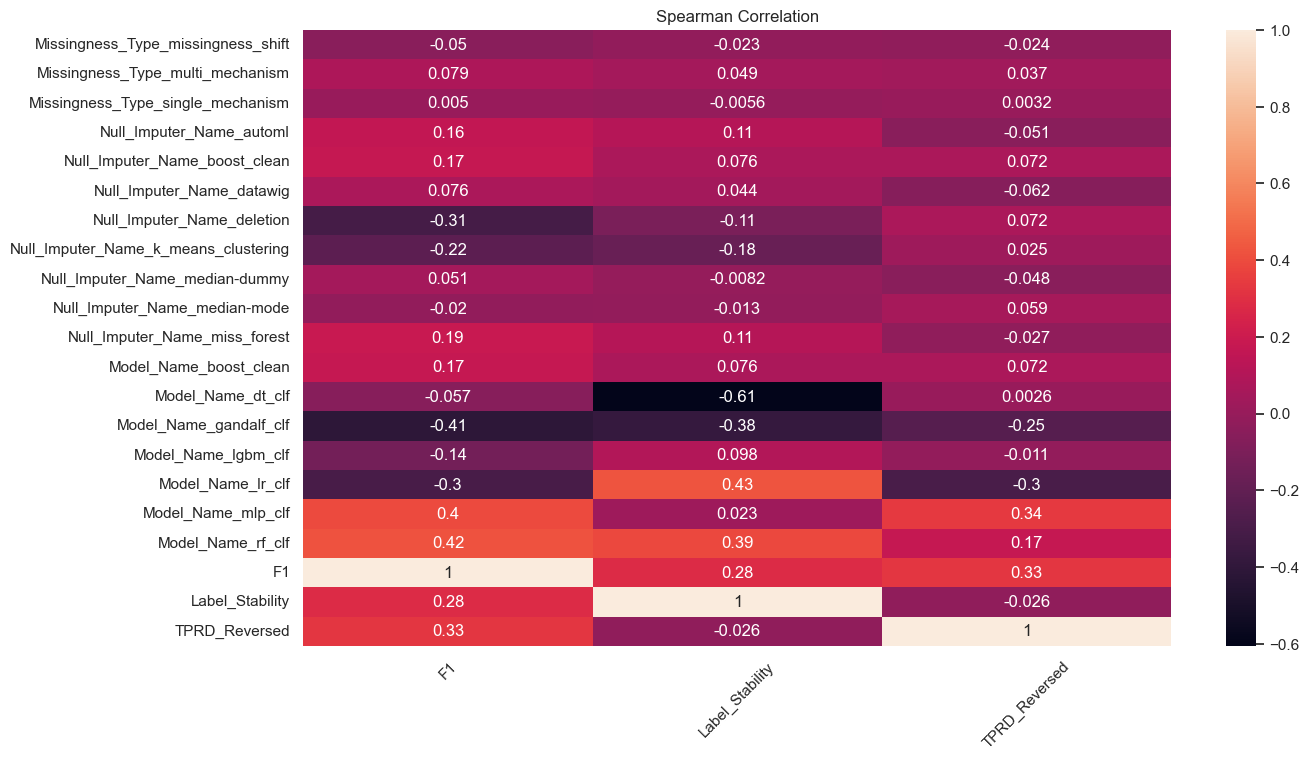

In [15]:
target_metrics = ['F1', 'Label_Stability', 'TPRD_Reversed']
get_correlation_matrix_by_target_names(df=metrics_df_encoded,
                                       feature_names=columns_for_correlation + target_metrics,
                                       target_names=target_metrics,
                                       heatmap_size=(8, 14),
                                       xticks_rotation=45)

In [16]:
db_client_1.close()
db_client_3.close()